In [1]:
import geopandas as gpd
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.2-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
streets = gpd.GeoDataFrame()

In [3]:
file_list = glob.glob('*shp')

In [4]:
for file in file_list:
    ds = gpd.read_file(file)
    streets = gpd.GeoDataFrame(pd.concat([streets, ds], ignore_index=True))

In [5]:
streets['adj_name'] = streets['name'].str.extract(r'^([^/]*)')

In [6]:
streets['adj_name_2'] = streets['adj_name'].str.replace('(North|East|West|South)\s', '', regex=True)
streets['adj_name_2'] = streets['adj_name_2'].str.rstrip()

In [7]:
crashes = pd.read_csv('/Users/michaelrosen/Desktop/Capstone/Crash .csvs/york_and_silverlake_crashes.csv')

In [8]:
streets_list = ['YORK', 'BRONSON', 'AVENUE 64', 'REDONDO','4TH','RIMPAU','WABASH','TUJUNGA','EDGEMONT', 'CRESCENT HEIGHTS', 'GRIFFIN', '54TH','LINCOLN PARK','19TH', '108TH', '92ND','EVERGREEN','TOWNSEND','COLFAX', 'HAUSER', 'JEFFERSON','BEVERLY GLEN','8TH','STRATHERN','GOWER','SILVER LAKE', 'FULTON', 'WILTON', 'BURBANK','NATIONAL']

In [9]:
target_crs = 'EPSG:26911'
streets = streets.to_crs(target_crs)
distance=8
streets['buffer_geom'] = streets.geometry.buffer(distance)

In [10]:
crashes_gdf = gpd.GeoDataFrame(
    crashes, geometry=gpd.points_from_xy(crashes.POINT_X, crashes.POINT_Y))

In [11]:
crashes_gdf = crashes_gdf.set_crs(epsg=4326)

In [12]:
crashes_gdf = crashes_gdf.to_crs(target_crs)

In [13]:
streets = streets[['adj_name_2', 'buffer_geom']]

In [14]:
streets_gdf = gpd.GeoDataFrame(streets, geometry='buffer_geom')

In [15]:
join = gpd.sjoin(streets_gdf, crashes_gdf, how='left', predicate='intersects')

In [16]:
filtered_join = join[join['PRIMARY_RD'].str.contains('|'.join(streets_list), case=False, na=False)]

In [17]:
streets_dict = {
    '2011-01-02': ['York Boulevard', 'Bronson Avenue', 'Avenue 64', 'Redondo Boulevard', '4th Street', 'Rimpau Boulevard', 'Wabash Avenue', 'Tujunga Avenue'],
    '2015-08-06': ['Edgemont Street', 'Crescent Heights Boulevard', 'Griffin Avenue', '54th Street', 'Lincoln Park Avenue'],
    '2019-09-09': ['19th Street', '108th Street', '92nd Street', 'Evergreen Avenue', 'Townsend Avenue'],
    '2021-08-03': ['Colfax Avenue', 'Hauser Boulevard', 'Jefferson Boulevard', 'Beverly Glen Boulevard', '8th Street', 'Strathern Street', 'Gower Street'],
    '2011-01-01': ['Silver Lake Boulevard', 'Fulton Avenue', 'Wilton Place', 'Burbank Boulevard', 'National Boulevard']
}

dates = pd.to_datetime(list(streets_dict.keys()))

df = pd.DataFrame(columns=['adj_name_2', 'crash_counts', 'days_elapsed'])

end_date = pd.Timestamp('2022-12-31')
days_elapsed = (end_date - dates).days

# Loop through dictionary and filter filtered_join DataFrame
# Loop through dictionary and filter filtered_join DataFrame
for date, streets in streets_dict.items():
    filtered_data = filtered_join[(filtered_join['adj_name_2'].isin(streets)) & (pd.to_datetime(filtered_join['COLLISION_DATE']) > pd.to_datetime(date))]
    counts = filtered_data['adj_name_2'].value_counts()
    
    # Add missing street names with zero counts
    missing_streets = set(streets) - set(counts.index)
    missing_counts = pd.Series(0, index=list(missing_streets))
    counts = counts.append(missing_counts)
    
    counts_df = pd.DataFrame({'adj_name_2': counts.index, 'crash_counts': counts.values})
    days_elapsed_df = pd.DataFrame({'days_elapsed': [days_elapsed[dates == pd.to_datetime(date)][0]] * len(counts)})
    merged_df = pd.concat([counts_df, days_elapsed_df], axis=1)
    df = pd.concat([df, merged_df], axis=0, ignore_index=True)


In [18]:
crash_counts = df

In [19]:
fatal_severe_crashes = filtered_join[filtered_join['COLLISION_SEVERITY'].isin([1.0, 2.0])]

In [20]:
new_df = pd.DataFrame(columns=['adj_name_2', 'fatal_severe_crash_counts', 'days_elapsed'])

for date, streets in streets_dict.items():
    filtered_data = fatal_severe_crashes[(fatal_severe_crashes['adj_name_2'].isin(streets)) & (pd.to_datetime(fatal_severe_crashes['COLLISION_DATE']) > pd.to_datetime(date))]
    counts = filtered_data['adj_name_2'].value_counts()
    counts_df = pd.DataFrame({'adj_name_2': streets})
    counts_df['fatal_severe_crash_counts'] = counts_df['adj_name_2'].map(counts).fillna(0)
    days_elapsed_df = pd.DataFrame({'days_elapsed': [days_elapsed[dates == pd.to_datetime(date)][0]] * len(streets)})
    merged_df = pd.concat([counts_df, days_elapsed_df], axis=1)
    new_df = pd.concat([new_df, merged_df], axis=0, ignore_index=True)


In [21]:
fatal_severe_crashes = new_df

In [22]:
ped_bike_crashes = filtered_join[(filtered_join['PEDESTRIAN_ACCIDENT'] == 'Y') | (filtered_join['BICYCLE_ACCIDENT'] == 'Y')]

In [23]:
ped_bike_df = pd.DataFrame(columns=['adj_name_2', 'ped_crash_counts'])

for date, streets in streets_dict.items():
    filtered_data = ped_bike_crashes[(ped_bike_crashes['adj_name_2'].isin(streets)) & (pd.to_datetime(ped_bike_crashes['COLLISION_DATE']) > pd.to_datetime(date))]
    counts = filtered_data['adj_name_2'].value_counts()
    counts_df = pd.DataFrame({'adj_name_2': streets})
    counts_df['ped_crash_counts'] = counts_df['adj_name_2'].map(counts).fillna(0)
    merged_df = pd.concat([counts_df], axis=1)
    ped_bike_df = pd.concat([ped_bike_df, merged_df], axis=0, ignore_index=True)


In [24]:
AADT=pd.read_excel('/Users/michaelrosen/Desktop/Capstone/AADT_Counts/Streetlight_AADT_Counts_FINAL.xlsx')

In [25]:
all_crashes = crash_counts.merge(fatal_severe_crashes, on = 'adj_name_2',how='left')

In [26]:
all_crashes = all_crashes.merge(ped_bike_df, on = 'adj_name_2',how='left')

In [27]:
all_crashes = all_crashes.merge(AADT,left_on = 'adj_name_2',right_on = 'Zone Name',how='left')

In [28]:
all_crashes['VMT'] = all_crashes['Miles']*all_crashes['AADT']*all_crashes['days_elapsed_x']
all_crashes['crashes_per_million_VMT'] = all_crashes['crash_counts']/(all_crashes['VMT']/1000000)
all_crashes['fatal_severe_crashes_per_million_VMT'] = all_crashes['fatal_severe_crash_counts']/(all_crashes['VMT']/1000000)
all_crashes['bike_ped_crashes_per_million_VMT'] = all_crashes['ped_crash_counts']/(all_crashes['VMT']/1000000)

In [29]:
all_crashes = all_crashes.drop(all_crashes[all_crashes['adj_name_2'] == '108th Street'].index)

In [30]:
# Calculate the mean crash counts for the control and comparison corridors
treatment_mean_total = all_crashes.loc[all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'crashes_per_million_VMT'].mean()
comparison_mean_total = all_crashes.loc[~all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'crashes_per_million_VMT'].mean()

# Calculate the percentage difference in means
percent_diff_total = (comparison_mean_total - treatment_mean_total) / treatment_mean_total * 100


In [31]:
treatment_mean_total

1.4030231614355597

In [32]:
comparison_mean_total

1.8485231133102218

In [33]:
percent_diff_total

31.75285797982343

In [34]:
# Calculate the mean fatal/severe crash counts for the control and comparison corridors
treatment_mean_fatal_severe = all_crashes.loc[all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'fatal_severe_crashes_per_million_VMT'].mean()
comparison_mean_fatal_severe = all_crashes.loc[~all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'fatal_severe_crashes_per_million_VMT'].mean()

# Calculate the percentage difference in means
percent_diff_fatal_severe = (comparison_mean_fatal_severe - treatment_mean_fatal_severe) / treatment_mean_fatal_severe * 100


In [39]:
comparison_mean_fatal_severe

0.21894431130377576

In [35]:
percent_diff_fatal_severe

53.36805096008288

In [36]:
# Calculate the mean fatal/severe crash counts for the control and comparison corridors
treatment_mean_ped_bike = all_crashes.loc[all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'bike_ped_crashes_per_million_VMT'].mean()
comparison_mean_ped_bike = all_crashes.loc[~all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'bike_ped_crashes_per_million_VMT'].mean()

# Calculate the percentage difference in means
percent_diff_ped_bike = (comparison_mean_ped_bike - treatment_mean_ped_bike) / treatment_mean_ped_bike * 100


In [40]:
comparison_mean_ped_bike

0.48052919774512143

In [37]:
percent_diff_ped_bike

9.376487927046215

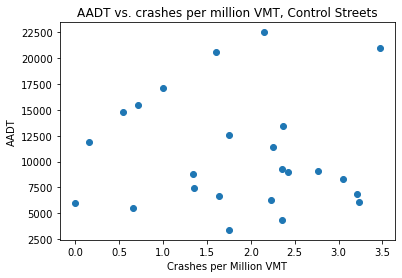

In [38]:
corrcoef_data = all_crashes[all_crashes['CLOSEST'] != 'Treatment Corridor']

# Convert 'crashes_per_million_VMT' and 'AADT' columns to floats for the filtered data
crashes_per_million_VMT = corrcoef_data['crashes_per_million_VMT'].astype(float)
AADT = corrcoef_data['AADT']

# Calculate the correlation coefficient
corr = np.corrcoef(crashes_per_million_VMT, AADT)[0, 1]

# Create a scatter plot
plt.scatter(crashes_per_million_VMT, AADT)
plt.xlabel('Crashes per Million VMT')
plt.ylabel('AADT')
plt.title('AADT vs. crashes per million VMT, Control Streets')
plt.savefig('AADT.png', dpi=300)
